**Attribute-Oriented** **Induction**

In [ ]:
import pandas as pd
data = pd.read_csv('Electric_Vehicle_Data.csv')

1) Attribute Removal

Remove irrelevant attributes - VIN, DOL Vehicle ID, Vehicle Location are removed as they are identifiers

In [ ]:
missing_values = data.isnull().sum()

columns_with_missing = missing_values[missing_values > 0]

print("Columns with missing values:")
print(columns_with_missing)

Columns with missing values:
County                    3
City                      3
Postal Code               3
Legislative District    398
Vehicle Location          8
Electric Utility          3
2020 Census Tract         3
dtype: int64


In [ ]:
data = data.drop(columns=['Legislative District'])
data = data.dropna()

In [ ]:
data = data.drop(columns=['VIN (1-10)', 'Base MSRP', 'Vehicle Location', 'State'])

2)Attribute Generalization

In [ ]:
# Generalize 'Model Year' into categories and add as a new column
def generalize_model_year(year):
    if year <= 2015:
        return 'Old'
    elif 2016 <= year <= 2019:
        return 'Moderate'
    else:
        return 'New'

# Add a new column for generalized 'Model Year'
data['Generalized Model Year'] = data['Model Year'].apply(generalize_model_year)

# Generalize 'Electric Range' into categories and add as a new column
def generalize_range(range_value):
    if range_value < 50:
        return 'Low Range'
    elif 50 <= range_value <= 150:
        return 'Moderate Range'
    else:
        return 'High Range'

# Add a new column for generalized 'Electric Range'
data['Generalized Electric Range'] = data['Electric Range'].apply(generalize_range)

# Generalize 'CAFV Eligibility' and add as a new column
data['Generalized CAFV Eligibility'] = data['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].apply(
    lambda x: 'Eligible' if 'Eligible' in x else 'Not Eligible')

# Generalize 'Make' into broad categories and add as a new column
def generalize_make(make):
    if make in ['TESLA', 'NISSAN', 'CHEVROLET']:
        return 'Popular EV Brands'
    else:
        return 'Other Brands'

# Add a new column for generalized 'Make'
data['Generalized Make'] = data['Make'].apply(generalize_make)

# Step 4: Aggregation - Aggregate the data based on new generalized attributes
# Group by generalized attributes and count occurrences
aggregated_data = data.groupby(
    ['Model Year','Generalized Model Year', 'Make','Generalized Make', 'Electric Vehicle Type', 'Electric Range',
     'Generalized Electric Range', 'Generalized CAFV Eligibility']
).size().reset_index(name='Count')

# Display the aggregated data with counts based on generalized attributes
print("\nAggregated Data Based on Generalized Attributes:")
print(aggregated_data.to_string(index=False))


Aggregated Data Based on Generalized Attributes:
 Model Year Generalized Model Year                 Make  Generalized Make                  Electric Vehicle Type  Electric Range Generalized Electric Range Generalized CAFV Eligibility  Count
       1997                    Old            CHEVROLET Popular EV Brands         Battery Electric Vehicle (BEV)              39                  Low Range                     Eligible      1
       1998                    Old                 FORD      Other Brands         Battery Electric Vehicle (BEV)              58             Moderate Range                     Eligible      1
       1999                    Old                 FORD      Other Brands         Battery Electric Vehicle (BEV)              74             Moderate Range                     Eligible      5
       2000                    Old                 FORD      Other Brands         Battery Electric Vehicle (BEV)              58             Moderate Range                     Eligib

In [ ]:
summary_counts = aggregated_data.groupby(
    ['Generalized Model Year', 'Generalized Make', 'Electric Vehicle Type',
     'Generalized Electric Range', 'Generalized CAFV Eligibility']
)['Count'].sum().reset_index()

# Display the summary counts
print("\nSummary Counts of Generalized Attributes:")
print(summary_counts.to_string(index=False))


Summary Counts of Generalized Attributes:
Generalized Model Year  Generalized Make                  Electric Vehicle Type Generalized Electric Range Generalized CAFV Eligibility  Count
              Moderate      Other Brands         Battery Electric Vehicle (BEV)                 High Range                     Eligible   1209
              Moderate      Other Brands         Battery Electric Vehicle (BEV)                  Low Range                 Not Eligible     12
              Moderate      Other Brands         Battery Electric Vehicle (BEV)             Moderate Range                     Eligible   2395
              Moderate      Other Brands Plug-in Hybrid Electric Vehicle (PHEV)                  Low Range                     Eligible   1493
              Moderate      Other Brands Plug-in Hybrid Electric Vehicle (PHEV)                  Low Range                 Not Eligible   7490
              Moderate      Other Brands Plug-in Hybrid Electric Vehicle (PHEV)             Moderat

## BUC Algorithm Implementation
Implement the Bottom-Up Cube (BUC) algorithm.

### In-Memory Implementation:
Assume that all CUBEs can be supported by the main memory and write a straightforward implementation of BUC.

In [ ]:
import time

def aggregate(df, group_by_cols):
    """Aggregate the data by counting occurrences for each combination of group_by_cols."""
    return df.groupby(group_by_cols).size().reset_index(name='Count')

def buc(df, dimensions, minsup=1, dim_index=0):
    """Recursive BUC algorithm for in-memory computation."""
    if dim_index == len(dimensions):
        return [aggregate(df, dimensions)]

    results = []

    # Get the current dimension to group by
    current_dim = dimensions[dim_index]

    # Get unique values in the current dimension
    unique_vals = df[current_dim].unique()

    # For each unique value, recursively call BUC on the sub-dataframe
    for val in unique_vals:
        sub_df = df[df[current_dim] == val]
        if len(sub_df) >= minsup:
            sub_cubes = buc(sub_df, dimensions, minsup, dim_index + 1)
            for sub_cube in sub_cubes:
                sub_cube[current_dim] = val
            results.extend(sub_cubes)

    # Compute the aggregate without grouping by the current dimension
    aggregate_without_dim = buc(df, dimensions, minsup, dim_index + 1)
    for agg in aggregate_without_dim:
        agg[current_dim] = 'ALL'
    results.extend(aggregate_without_dim)

    return results

data_small = data[['Model Year', 'Make', 'Electric Vehicle Type']]
dimensions = ['Model Year', 'Make', 'Electric Vehicle Type']
minsup = 2

# Run the BUC algorithm
start_time = time.time()
cubes = buc(data_small, dimensions, minsup)
end_time = time.time()

# Combine results into a single DataFrame
buc_result = pd.concat(cubes, ignore_index=True)
buc_result = buc_result.groupby(dimensions).sum().reset_index()

# Display the result
buc_result.head()
print(f"Execution Time: {end_time - start_time} seconds")



Execution Time: 5.538098096847534 seconds


### Out-of-Memory Implementation:
Assume that the program will run out of main memory and introduce paging in your implementation.

In [ ]:
## OUT-Memory Implementation of BUC Algorithm
import os

def buc_out_of_memory(input_file, dimensions, output_file, minsup=1, chunk_size=10000):
    """BUC algorithm with paging for out-of-memory computation."""
    temp_files = []
    chunk_no = 0

    for chunk in pd.read_csv(input_file, chunksize=chunk_size):
        chunk_file = f"temp_chunk_{chunk_no}.csv"
        temp_files.append(chunk_file)
        chunk.to_csv(chunk_file, index=False)
        chunk_no += 1

    results = []
    for temp_file in temp_files:
        df_chunk = pd.read_csv(temp_file)
        cubes = buc(df_chunk, dimensions, minsup)
        for cube in cubes:
            cube.to_csv(output_file, mode='a', header=not os.path.exists(output_file), index=False)
        os.remove(temp_file)

    return pd.read_csv(output_file)

input_file = 'Electric_Vehicle_Data.csv'
output_file = 'buc_out_memory_result.csv'

# Run the Out-of-Memory BUC algorithm
start_time = time.time()
buc_out_of_memory(input_file, dimensions, output_file, minsup, chunk_size=5000)
end_time = time.time()

# Display the first few rows of the result
buc_out_of_memory_result = pd.read_csv(output_file)
buc_out_of_memory_result.head()
print(f"Execution Time: {end_time - start_time} seconds")

Execution Time: 82.65355849266052 seconds


### Performance Analysis
1. A plot of minsup vs. runtime, keeping allotted memory fixed.
<br></br>
2. A plot of allotted memory vs. runtime, keeping minsup fixed

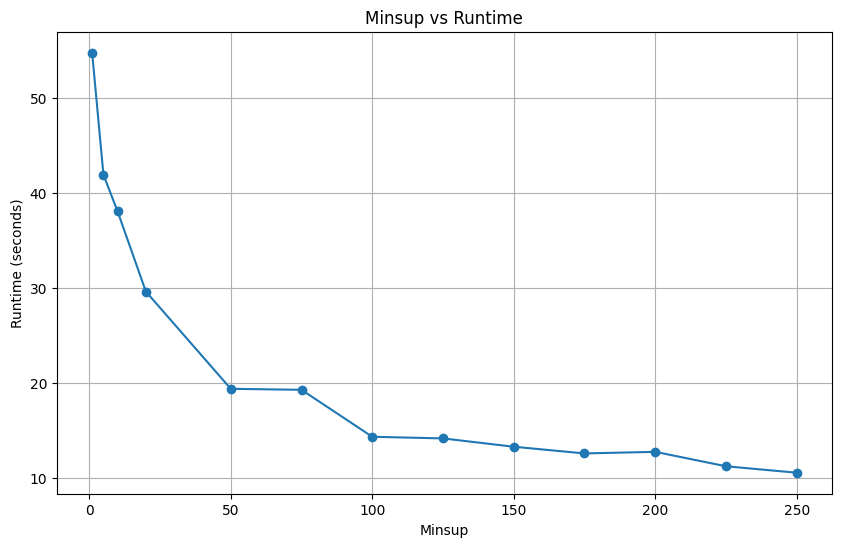

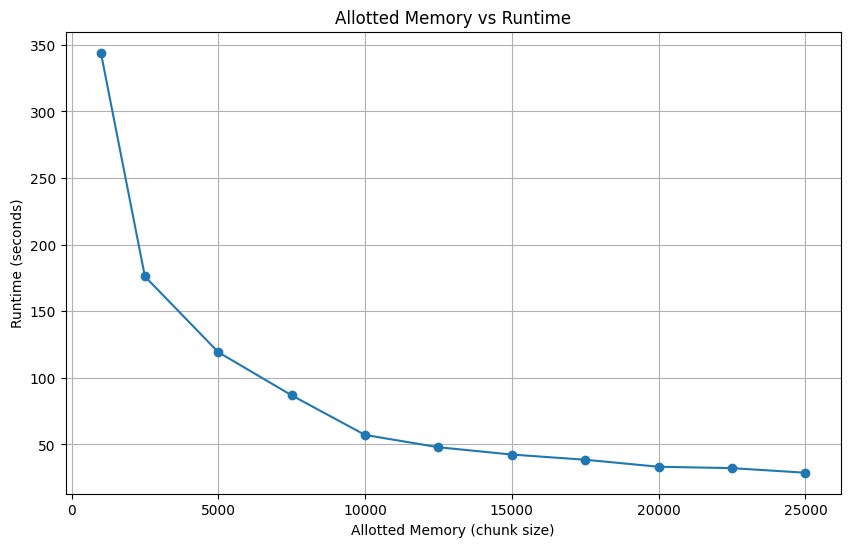

In [ ]:
## Performace
import matplotlib.pyplot as plt

def performance_analysis(input_file, dimensions, minsups, memories, chunk_size=10000):
    """Analyze the performance by plotting runtime vs minsup and memory allocations."""
    runtimes_minsup = []
    for minsup in minsups:
        start_time = time.time()
        buc_out_of_memory(input_file, dimensions, 'temp_result.csv', minsup, chunk_size)
        end_time = time.time()
        runtimes_minsup.append(end_time - start_time)

    plt.figure(figsize=(10, 6))
    plt.plot(minsups, runtimes_minsup, marker='o')
    plt.title("Minsup vs Runtime")
    plt.xlabel("Minsup")
    plt.ylabel("Runtime (seconds)")
    plt.grid(True)
    plt.show()

    runtimes_memory = []
    for memory in memories:
        start_time = time.time()
        buc_out_of_memory(input_file, dimensions, 'temp_result.csv', minsup=1, chunk_size=memory)
        end_time = time.time()
        runtimes_memory.append(end_time - start_time)

    plt.figure(figsize=(10, 6))
    plt.plot(memories, runtimes_memory, marker='o')
    plt.title("Allotted Memory vs Runtime")
    plt.xlabel("Allotted Memory (chunk size)")
    plt.ylabel("Runtime (seconds)")
    plt.grid(True)
    plt.show()

minsups = [1, 5, 10, 20, 50,75, 100, 125, 150, 175, 200, 225, 250]
memories = [1000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000]

performance_analysis(input_file, dimensions, minsups, memories)

### Optimization Technique:

In [ ]:

def calculate_cardinality_and_skew(df, dimensions):
    """Calculate cardinality and skew for each dimension."""
    stats = []
    for dim in dimensions:
        cardinality = df[dim].nunique()
        skewness = df[dim].value_counts(normalize=True).max()
        stats.append((dim, cardinality, skewness))
    return stats

def order_dimensions(stats):
    """Order dimensions based on decreasing cardinality and increasing skewness."""
    return sorted(stats, key=lambda x: (-x[1], x[2]))

def dynamic_buc(df, dimensions, minsup=1, dim_index=0):
    """BUC algorithm with dynamic dimension ordering for in-memory computation."""
    if dim_index == len(dimensions):
        return [aggregate(df, dimensions)]

    results = []
    current_dim = dimensions[dim_index]

    unique_vals = df[current_dim].unique()

    for val in unique_vals:
        sub_df = df[df[current_dim] == val]
        if len(sub_df) >= minsup:
            sub_cubes = dynamic_buc(sub_df, dimensions, minsup, dim_index + 1)
            for sub_cube in sub_cubes:
                sub_cube[current_dim] = val
            results.extend(sub_cubes)

    aggregate_without_dim = dynamic_buc(df, dimensions, minsup, dim_index + 1)
    for agg in aggregate_without_dim:
        agg[current_dim] = 'ALL'
    results.extend(aggregate_without_dim)

    return results

data_small = data[['Model Year', 'Make', 'Electric Vehicle Type']].head(1000)
dimensions = ['Model Year', 'Make', 'Electric Vehicle Type']

# Step 1: Calculate statistics and order dimensions
stats = calculate_cardinality_and_skew(data_small, dimensions)
ordered_dimensions = [dim[0] for dim in order_dimensions(stats)]

# Step 2: Run the Dynamic BUC algorithm
start_time = time.time()
cubes = dynamic_buc(data_small, ordered_dimensions, minsup=2)
end_time = time.time()

# Combine results into a single DataFrame
dynamic_buc_result = pd.concat(cubes, ignore_index=True)
dynamic_buc_result = dynamic_buc_result.groupby(ordered_dimensions).sum().reset_index()

# Display the result
dynamic_buc_result.head()
print(f"Execution Time: {end_time - start_time} seconds")

Execution Time: 1.2021512985229492 seconds


### Impact of Optimization on performance


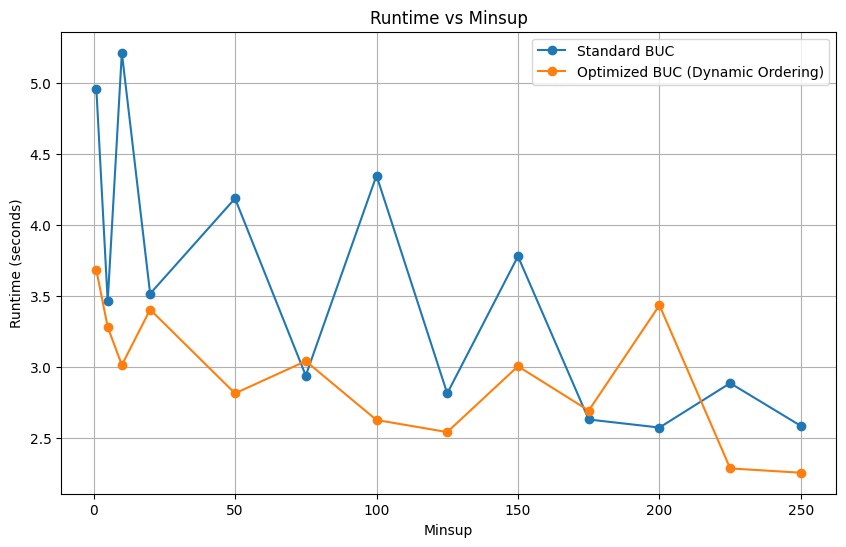

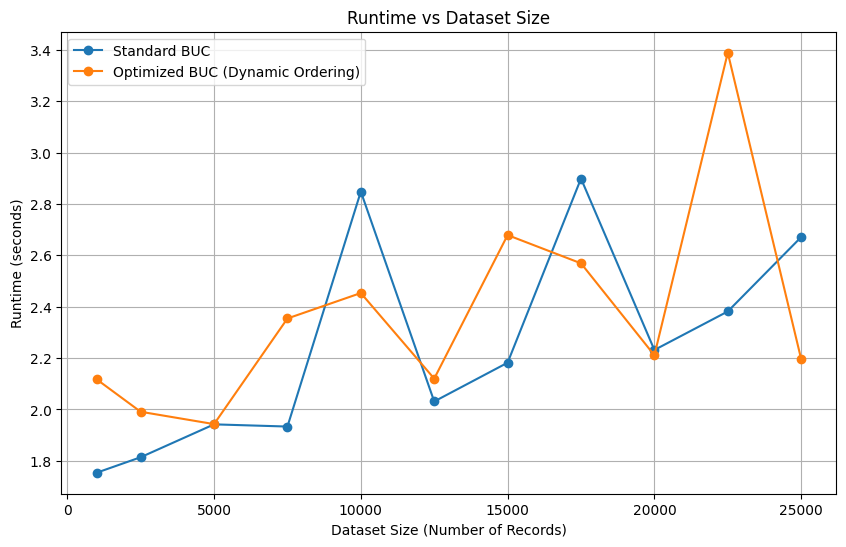

In [ ]:
import matplotlib.pyplot as plt
import time
def compare_buc_algorithms(input_data, dimensions, minsups, sizes):
    """Compare standard BUC with optimized BUC on different minsup and dataset sizes."""
    runtime_standard = []
    runtime_optimized = []

    # Compare runtime with varying minsup
    for minsup in minsups:
        # Standard BUC
        start_time = time.time()
        standard_cubes = buc(input_data, dimensions, minsup)
        runtime_standard.append(time.time() - start_time)

        # Optimized BUC
        start_time = time.time()
        stats = calculate_cardinality_and_skew(input_data, dimensions)
        ordered_dimensions = [dim[0] for dim in order_dimensions(stats)]
        optimized_cubes = dynamic_buc(input_data, ordered_dimensions, minsup)
        runtime_optimized.append(time.time() - start_time)

    # Plotting minsup vs runtime
    plt.figure(figsize=(10, 6))
    plt.plot(minsups, runtime_standard, marker='o', label='Standard BUC')
    plt.plot(minsups, runtime_optimized, marker='o', label='Optimized BUC (Dynamic Ordering)')
    plt.title("Runtime vs Minsup")
    plt.xlabel("Minsup")
    plt.ylabel("Runtime (seconds)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Compare runtime with varying dataset size
    runtime_standard = []
    runtime_optimized = []

    for size in sizes:
        # Take a sample of the dataset
        sample_data = input_data.sample(size)

        # Standard BUC
        start_time = time.time()
        standard_cubes = buc(sample_data, dimensions, minsup=1)
        runtime_standard.append(time.time() - start_time)

        # Optimized BUC
        start_time = time.time()
        stats = calculate_cardinality_and_skew(sample_data, dimensions)
        ordered_dimensions = [dim[0] for dim in order_dimensions(stats)]
        optimized_cubes = dynamic_buc(sample_data, ordered_dimensions, minsup=1)
        runtime_optimized.append(time.time() - start_time)

    # Plotting dataset size vs runtime
    plt.figure(figsize=(10, 6))
    plt.plot(sizes, runtime_standard, marker='o', label='Standard BUC')
    plt.plot(sizes, runtime_optimized, marker='o', label='Optimized BUC (Dynamic Ordering)')
    plt.title("Runtime vs Dataset Size")
    plt.xlabel("Dataset Size (Number of Records)")
    plt.ylabel("Runtime (seconds)")
    plt.legend()
    plt.grid(True)
    plt.show()

input_data = data[['Model Year', 'Make', 'Electric Vehicle Type']]
dimensions = ['Model Year', 'Make', 'Electric Vehicle Type']

minsups = [1, 5, 10, 20, 50,75, 100, 125, 150, 175, 200, 225, 250]
memories = [1000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000]

compare_buc_algorithms(input_data, dimensions, minsups, memories)
